In [342]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff
import datetime
import pandas as pd
from pandas import RangeIndex
import yfinance as yf
import numpy as np
import scipy as sp
from scipy.optimize import minimize


In [343]:
# Create a random vector of multiple assets within x amount of portfolios
portfolios = 1000
assets = 6
returned_vector = np.random.randn(assets,portfolios)


In [344]:
# Before we actually analyze real stocks we need to set the stage for the portfolio optimization
# create random stock weights for analysis, the weights of the assets MUST sum to 1

assets = 6
mean_variance = []

def random_weights(assets):
    k = np.random.rand(assets)
    return k/sum(k)

random_weights(assets)

array([0.08360623, 0.34110674, 0.081292  , 0.24812294, 0.04036275,
       0.20550934])

In [345]:
# We are going to randomize returns
def random_portfolio(returns):

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(random_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This code below is necessary to get rid of outliers
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

In [346]:
# Generate a vast number of random portfolios for simulation
means, stds = np.column_stack([
    random_portfolio(returned_vector)
    for _ in RangeIndex(portfolios)
])

Text(0.5, 1.0, 'Mean and standard deviation of returns of randomly generated portfolios')

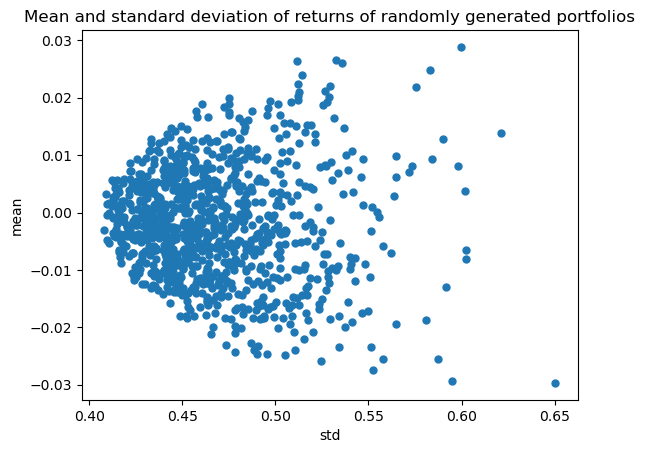

In [347]:
fig = plt.figure()
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')


     pcost       dcost       gap    pres   dres
 0:  1.5571e-03 -1.0467e+00  1e+00  1e-16  3e+00
 1: -6.2096e-04 -5.4920e-02  5e-02  2e-16  2e-01
 2: -1.7828e-02 -3.0509e-02  1e-02  2e-16  5e-17
 3: -2.0927e-02 -2.1705e-02  8e-04  1e-16  2e-17
 4: -2.1315e-02 -2.1371e-02  6e-05  6e-17  4e-17
 5: -2.1349e-02 -2.1355e-02  6e-06  3e-17  1e-17
 6: -2.1354e-02 -2.1354e-02  3e-07  1e-16  1e-17
 7: -2.1354e-02 -2.1354e-02  3e-09  2e-16  2e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.6847e-03 -1.0452e+00  1e+00  0e+00  3e+00
 1:  5.5383e-04 -5.3272e-02  5e-02  3e-17  2e-01
 2: -1.5380e-02 -2.7029e-02  1e-02  2e-16  2e-17
 3: -1.8451e-02 -1.9061e-02  6e-04  2e-16  2e-17
 4: -1.8753e-02 -1.8793e-02  4e-05  1e-16  2e-17
 5: -1.8761e-02 -1.8764e-02  3e-06  1e-16  2e-17
 6: -1.8762e-02 -1.8762e-02  3e-08  1e-16  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.9458e-03 -1.0436e+00  1e+00  1e-16  3e+00
 1:  1.8663e-03 -5.1437e

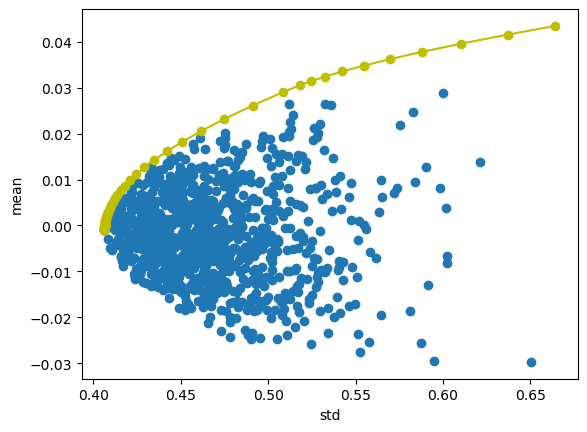

In [348]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

weights, returns, risks = optimal_portfolio(returned_vector)

fig = plt.figure()
plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')


In [349]:
# Finally print the weights we will use
print(weights)

[[1.87048243e-01]
 [7.25194154e-09]
 [1.97858177e-09]
 [7.67105035e-05]
 [1.76161476e-09]
 [8.12875036e-01]]


In [350]:
# Time to use real world data

jm = yf.download('JPM', start='2012-01-01', end='2022-12-31')
ap = yf.download('AAPL', start='2012-01-01', end='2022-12-31')
am = yf.download('AMZN', start='2012-01-01', end='2022-12-31')
wm = yf.download('WMT', start='2012-01-01', end='2022-12-31')
tg = yf.download('TGT', start='2012-01-01', end='2022-12-31')
ms = yf.download('MSFT', start='2012-01-01', end='2022-12-31')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [351]:
stocks = pd.concat([jm['Adj Close'], ap['Adj Close'], am['Adj Close'], wm['Adj Close'], tg['Adj Close'], ms['Adj Close']],axis=1)
stocks.columns = ['JP Morgan', 'Apple', 'Amazon', 'Walmart', 'Target', 'Microsoft']
stocks.to_csv('stock_data.csv')
stocks.head()

,JP Morgan,Apple,Amazon,Walmart,Target,Microsoft
Date,,,,,,
2012-01-03,25.349653,12.482926,8.9515,46.785133,37.425644,21.366358
2012-01-04,25.510235,12.550010,8.8755,46.304340,36.605686,21.869194
2012-01-05,26.043062,12.689342,8.8805,46.079437,35.514843,22.092670
2012-01-06,25.809496,12.821994,9.1305,45.753738,35.836956,22.435875
2012-01-09,25.765697,12.801656,8.9280,45.893326,35.558773,22.140554


In [352]:
# Find Returns

returns = stocks/stocks.shift(1)
returns

,JP Morgan,Apple,Amazon,Walmart,Target,Microsoft
Date,,,,,,
2012-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-04,1.006335,1.005374,0.991510,0.989723,0.978091,1.023534
2012-01-05,1.020887,1.011102,1.000563,0.995143,0.970200,1.010219
2012-01-06,0.991032,1.010454,1.028152,0.992932,1.009070,1.015535
2012-01-09,0.998303,0.998414,0.977822,1.003051,0.992238,0.986837
...,...,...,...,...,...,...
2022-12-23,1.004745,0.997202,1.017425,1.002021,1.012734,1.002267
2022-12-27,1.003504,0.986122,0.974076,1.000278,1.016766,0.992586
2022-12-28,1.005465,0.969315,0.985308,0.982477,1.001717,0.989745


In [353]:
# Fine the mean of the returns

returns.mean()

JP Morgan    1.000740
Apple        1.001014
Amazon       1.001018
Walmart      1.000479
Target       1.000655
Microsoft    1.001012
dtype: float64

In [354]:
# Need to take the logarithm of the mean for future risk analysis

log_returns = np.log(returns) 
log_returns.to_csv('stock_data.csv', index=True)
log_returns

,JP Morgan,Apple,Amazon,Walmart,Target,Microsoft
Date,,,,,,
2012-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-04,0.006315,0.005360,-0.008526,-0.010330,-0.022153,0.023261
2012-01-05,0.020672,0.011041,0.000563,-0.004869,-0.030253,0.010167
2012-01-06,-0.009009,0.010399,0.027763,-0.007093,0.009029,0.015415
2012-01-09,-0.001698,-0.001587,-0.022428,0.003046,-0.007793,-0.013250
...,...,...,...,...,...,...
2022-12-23,0.004734,-0.002802,0.017274,0.002019,0.012654,0.002265
2022-12-27,0.003498,-0.013976,-0.026266,0.000278,0.016627,-0.007442
2022-12-28,0.005450,-0.031166,-0.014801,-0.017679,0.001716,-0.010308


In [355]:
# Find the expected return of the portfolio and the deviation in the portfolio returns
expected_return = log_returns.mean() * 252
deviation_return = log_returns.cov() * 252
expected_return

JP Morgan    0.150330
Apple        0.213087
Amazon       0.203913
Walmart      0.100263
Target       0.124667
Microsoft    0.219795
dtype: float64

In [356]:
# Declare a minimum return % you want on your investment
minimum_return = 0.02
number_of_assets = 6
# Create a function to set up the risk return
def risk_analysis(w):
    return np.dot(w.T,np.dot(deviation_return,w))

# Set weight of stocks for evaluation
w0 = [0.166, 0.166, 0.166, 0.166, 0.166, 0.167]
bounds = ((0,1), (0,1), (0,1), (0,1), (0,1), (0,1))

# Creating minimum return function
def min_retrn(w):
    RHS = minimum_return - np.sum(expected_return * w)
    return RHS

def verify_min_return(w):
    return np.sum(w) - 1

constraints = ({'type': 'eq', 'fun': min_retrn},{'type': 'eq', 'fun': verify_min_return})
optimal_weights = minimize(risk_analysis, w0, method='SLSQP', bounds=bounds, constraints=constraints)

In [357]:
optimal_weights

 message: Positive directional derivative for linesearch
 success: False
  status: 8
     fun: 0.040682640677066916
       x: [ 2.259e-18  0.000e+00  4.973e-13  9.984e-01  3.898e-19
            1.907e-18]
     nit: 13
     jac: [ 2.868e-02  3.527e-02  3.205e-02  8.150e-02  5.292e-02
            3.689e-02]
    nfev: 113
    njev: 9

In [358]:
# use scipy for optimal weight vector

weight = optimal_weights.x
weight

array([2.25911399e-18, 0.00000000e+00, 4.97286972e-13, 9.98378767e-01,
       3.89806144e-19, 1.90731482e-18])

In [359]:
# Find weighted risk

weighted_risk = risk_analysis(weight)
weighted_risk

0.040682640677066916

In [360]:
# Take the sum of the expected return times weighted risk
np.sum(expected_return*weighted_risk)

0.04117301721134344

In [361]:
# Time for Markowitz
def markowitz(minimum_return,deviation_return,expected_return):
    N = len(deviation_return)
    o = np.ones(N)
    dev_sigma = np.linalg.inv(deviation_return)
    a = np.dot(expected_return.T, np.dot(dev_sigma,expected_return))
    b = np.dot(expected_return.T,np.dot(dev_sigma,o))
    c = np.dot(o.T,np.dot(dev_sigma,o))
    return (1/(a*c - b**2)) * np.dot(dev_sigma,((c*minimum_return - b)*expected_return + (a-b*minimum_return)*o))

In [362]:
# Now time to see the optimial risk for maximum returns with stock weights

final_analysis = markowitz(minimum_return,deviation_return,expected_return) *100
final_analysis

array([ 38.58030184, -25.52624812,   0.58698224, 133.27638481,
        16.08953956, -63.00696034])

### Now let's move to see the portfolio shocked to better see what is going on. 


In [363]:
daily_returns = pd.read_csv('stock_data.csv', index_col=0)
daily_returns.head()

,JP Morgan,Apple,Amazon,Walmart,Target,Microsoft
Date,,,,,,
2012-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-04,0.006315,0.005360,-0.008526,-0.010330,-0.022153,0.023261
2012-01-05,0.020672,0.011041,0.000563,-0.004869,-0.030253,0.010167
2012-01-06,-0.009009,0.010399,0.027763,-0.007093,0.009029,0.015415
2012-01-09,-0.001698,-0.001587,-0.022428,0.003046,-0.007793,-0.013250


In [364]:
# We need annualized mean returns
mus = (1+daily_returns.mean())**252 - 1

# We need the covariances of the stocks; mulitply covariance of stocks by trading days in a year, roughly 252 (this will give us)
# annualizing covariance is the square root time for volatility but no square root for variance
# a good resource for equations used --> https://quant.stackexchange.com/questions/43442/portfolio-variance-explanation-for-equation-investments-by-zvi-bodie

# a good resrouce of what annualized covariance means --> https://quant.stackexchange.com/questions/4753/annualized-covariance
cov = daily_returns.cov() * 252

In [365]:
# Indicate how many assests to include in each portfolio
number_assets = 6
# Indicate how many portfolios to generate
number_portfolios = 1000

# storing the variance pairs
mean_variance_pairs = []

np.random.seed(75)

for i in range(number_portfolios):
    
    # It is best to choose assets randomly without replacement
    assets = np.random.choice(list(daily_returns.columns), number_assets, replace=False)
    
    # It is best to choose weights randomly
    weights = np.random.rand(number_assets)
    
    # Must ensure weights sum to 1
    
    weights = weights/sum(weights)

    # Loop over asset pairs and compute portfolio return and variance
       
    portfolio_expected_variance = 0
    portfolio_expected_return = 0
    
    for i in range(len(assets)):
        portfolio_expected_return += weights[i] * mus.loc[assets[i]]
        for j in range(len(assets)):
            
            
            portfolio_expected_variance += weights[i] * weights[j] * cov.loc[assets[i], assets[j]]
            
    # Add the mean/variance pairs to a list for plotting
    mean_variance_pairs.append([portfolio_expected_return, portfolio_expected_variance])

In [366]:
#-- Plot the risk vs. return of randomly generated portfolios
#-- Convert the list from before into an array for easy plotting
mean_variance_pairs = np.array(mean_variance_pairs)

risk_free_rate=0 #-- Include risk free rate here

fig = go.Figure()
fig.add_trace(go.Scatter(x=mean_variance_pairs[:,1]**0.5, y=mean_variance_pairs[:,0], 
                      marker=dict(color=(mean_variance_pairs[:,0]-risk_free_rate)/(mean_variance_pairs[:,1]**0.5), 
                                  showscale=True, 
                                  size=7,
                                  line=dict(width=1),
                                  colorscale="Temps",
                                  colorbar=dict(title="Sharpe<br>Ratio")
                                 ), 
                      mode='markers'))
fig.update_layout(template='plotly_white',
                  xaxis=dict(title='Annualized Risk (Volatility)'),
                  yaxis=dict(title='Annualized Return'),
                  title='10-Year Markowitz Bullet on Anualized Returns/Volatility',
                  width=850,
                  height=500)
fig.update_xaxes(range=[0.20, 0.32])
fig.update_yaxes(range=[0.05,0.28])
fig.update_layout(coloraxis_colorbar=dict(title="Sharpe Ratio"))

In [367]:
# The expected return on our optimized portfolio return is 17.9%
portfolio_expected_return

0.17978238363896837

## Efficient Frontier for 10 Year Analysis

In [368]:
#-- Create random portfolio weights and indexes
#- How many assests in the portfolio
n_assets = 6

mean_variance_pairs = []
weights_list=[]
tickers_list=[]

for i in tqdm(range(10000)):
    next_i = False
    while True:
        #- Choose assets randomly without replacement
        assets = np.random.choice(list(daily_returns.columns), n_assets, replace=False)
        #- Choose weights randomly ensuring they sum to one
        weights = np.random.rand(n_assets)
        weights = weights/sum(weights)

        #-- Loop over asset pairs and compute portfolio return and variance
        portfolio_E_Variance = 0
        portfolio_E_Return = 0
        for i in range(len(assets)):
            portfolio_E_Return += weights[i] * mus.loc[assets[i]]
            for j in range(len(assets)):
                portfolio_E_Variance += weights[i] * weights[j] * cov.loc[assets[i], assets[j]]

        #-- Skip over dominated portfolios
        for R,V in mean_variance_pairs:
            if (R > portfolio_E_Return) & (V < portfolio_E_Variance):
                next_i = True
                break
        if next_i:
            break

        #-- Add the mean/variance pairs to a list for plotting
        mean_variance_pairs.append([portfolio_E_Return, portfolio_E_Variance])
        weights_list.append(weights)
        tickers_list.append(assets)
        break

100%|██████████| 10000/10000 [00:03<00:00, 2511.61it/s]


In [369]:
len(mean_variance_pairs)

268

In [370]:
#-- Plot the risk vs. return of randomly generated portfolios
#-- Convert the list from before into an array for easy plotting
mean_variance_pairs = np.array(mean_variance_pairs)

risk_free_rate=0 #-- Include risk free rate here

fig = go.Figure()
fig.add_trace(go.Scatter(x=mean_variance_pairs[:,1]**0.5, y=mean_variance_pairs[:,0], 
                      marker=dict(color=(mean_variance_pairs[:,0]-risk_free_rate)/(mean_variance_pairs[:,1]**0.5), 
                                  showscale=True, 
                                  size=7,
                                  line=dict(width=1),
                                  colorscale="Temps",
                                  colorbar=dict(title="Sharpe<br>Ratio")
                                 ), 
                      mode='markers',
                      text=[str(np.array(tickers_list[i])) + "<br>" + str(np.array(weights_list[i]).round(2)) for i in range(len(tickers_list))]))
fig.update_layout(template='plotly_white',
                  xaxis=dict(title='Annualized Risk (Volatility)'),
                  yaxis=dict(title='Annualized Return'),
                  title="10-year Optimized Portfolio",
                  width=850,
                  height=500)
fig.update_xaxes(range=[0.18, 0.35])
fig.update_yaxes(range=[0.05,0.29])
fig.update_layout(coloraxis_colorbar=dict(title="Sharpe Ratio"))

### Above is a ten year analysis, now we will do a five year analysis

In [371]:
jm = yf.download('JPM', start='2017-01-01', end='2022-12-31')
ap = yf.download('AAPL', start='2017-01-01', end='2022-12-31')
am = yf.download('AMZN', start='2017-01-01', end='2022-12-31')
wm = yf.download('WMT', start='2017-01-01', end='2022-12-31')
tg = yf.download('TGT', start='2017-01-01', end='2022-12-31')
ms = yf.download('MSFT', start='2017-01-01', end='2022-12-31')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [372]:
stocks = pd.concat([jm['Adj Close'], ap['Adj Close'], am['Adj Close'], wm['Adj Close'], tg['Adj Close'], ms['Adj Close']],axis=1)
stocks.columns = ['JP Morgan', 'Apple', 'Amazon', 'Walmart', 'Target', 'Microsoft']


In [373]:
returns = stocks/stocks.shift(1)
returns

,JP Morgan,Apple,Amazon,Walmart,Target,Microsoft
Date,,,,,,
2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,1.001845,0.998881,1.004657,1.005826,1.014570,0.995526
2017-01-05,0.990795,1.005085,1.030732,1.002172,0.983065,1.000000
2017-01-06,1.000116,1.011148,1.019912,0.986274,0.984565,1.008668
2017-01-09,1.000697,1.009159,1.001168,1.006592,0.999860,0.996817
...,...,...,...,...,...,...
2022-12-23,1.004745,0.997202,1.017425,1.002021,1.012734,1.002267
2022-12-27,1.003504,0.986122,0.974076,1.000278,1.016766,0.992586
2022-12-28,1.005465,0.969315,0.985308,0.982477,1.001717,0.989745


In [374]:
returns.mean()

JP Morgan    1.000574
Apple        1.001233
Amazon       1.000758
Walmart      1.000660
Target       1.000813
Microsoft    1.001112
dtype: float64

In [375]:
log_returns = np.log(returns)
log_returns.to_csv('five_stock_data.csv') 
log_returns

,JP Morgan,Apple,Amazon,Walmart,Target,Microsoft
Date,,,,,,
2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,0.001843,-0.001120,0.004646,0.005809,0.014465,-0.004484
2017-01-05,-0.009248,0.005072,0.030270,0.002170,-0.017080,0.000000
2017-01-06,0.000116,0.011087,0.019716,-0.013821,-0.015556,0.008631
2017-01-09,0.000697,0.009118,0.001168,0.006571,-0.000140,-0.003188
...,...,...,...,...,...,...
2022-12-23,0.004734,-0.002802,0.017274,0.002019,0.012654,0.002265
2022-12-27,0.003498,-0.013976,-0.026266,0.000278,0.016627,-0.007442
2022-12-28,0.005450,-0.031166,-0.014801,-0.017679,0.001716,-0.010308


In [376]:
expected_return = log_returns.mean() * 252
deviation_return = log_returns.cov() * 252
expected_return

JP Morgan    0.099789
Apple        0.261303
Amazon       0.133865
Walmart      0.140636
Target       0.146540
Microsoft    0.238069
dtype: float64

In [377]:
# Declare a minimum return % you want on your investment
minimum_return = 0.02
number_of_assets = 6
# Create a function to set up the risk return
def risk_analysis(w):
    return np.dot(w.T,np.dot(deviation_return,w))

# Set random weight of stocks for evaluation
w0 = [0.166, 0.166, 0.166, 0.166, 0.166, 0.167]
bounds = ((0,1), (0,1), (0,1), (0,1), (0,1), (0,1))

# Creating minimum return function
def min_retrn(w):
    RHS = minimum_return - np.sum(expected_return * w)
    return RHS

def verify_min_return(w):
    return np.sum(w) - 1 

constraints = ({'type': 'eq', 'fun': min_retrn},{'type': 'eq', 'fun': verify_min_return})
optimal_weights = minimize(risk_analysis, w0, method='SLSQP', bounds=bounds, constraints=constraints)

In [378]:
optimal_weights

 message: Positive directional derivative for linesearch
 success: False
  status: 8
     fun: 0.08960833539375022
       x: [ 9.984e-01  6.990e-18  4.973e-17  9.433e-13  4.535e-13
            6.652e-13]
     nit: 13
     jac: [ 1.795e-01  8.718e-02  6.383e-02  3.586e-02  6.626e-02
            8.583e-02]
    nfev: 131
    njev: 9

In [379]:
weight = optimal_weights.x
weight

array([9.98403066e-01, 6.99023027e-18, 4.97293580e-17, 9.43316431e-13,
       4.53479114e-13, 6.65199045e-13])

In [380]:
weighted_risk = risk_analysis(weight)
weighted_risk

0.08960833539375022

In [381]:
np.sum(expected_return*weighted_risk)

0.09141852840321611

In [382]:
# Time for Markowitz
def markowitz(minimum_return,deviation_return,expected_return):
    N = len(deviation_return)
    o = np.ones(N)
    dev_sigma = np.linalg.inv(deviation_return)
    a = np.dot(expected_return.T, np.dot(dev_sigma,expected_return))
    b = np.dot(expected_return.T,np.dot(dev_sigma,o))
    c = np.dot(o.T,np.dot(dev_sigma,o))
    return (1/(a*c - b**2)) * np.dot(dev_sigma,((c*minimum_return - b)*expected_return + (a-b*minimum_return)*o))

In [383]:
final_analysis = markowitz(minimum_return,deviation_return,expected_return) *100
final_analysis

array([ 58.71988991, -40.05423488,  55.40582153,  69.36371824,
         2.45413424, -45.88932904])

In [384]:
daily_returns = pd.read_csv('five_stock_data.csv', index_col=0)
daily_returns.head()

,JP Morgan,Apple,Amazon,Walmart,Target,Microsoft
Date,,,,,,
2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,0.001843,-0.001120,0.004646,0.005809,0.014465,-0.004484
2017-01-05,-0.009248,0.005072,0.030270,0.002170,-0.017080,0.000000
2017-01-06,0.000116,0.011087,0.019716,-0.013821,-0.015556,0.008631
2017-01-09,0.000697,0.009118,0.001168,0.006571,-0.000140,-0.003188


In [385]:
# We need annualized mean returns
mus = (1+daily_returns.mean())**252 - 1

# We need the covariances of the stocks; mulitply covariance of stocks by trading days in a year, roughly 252 (this will give us)
# annualizing covariance is the square root time for volatility but no square root for variance
# a good resource for equations used --> https://quant.stackexchange.com/questions/43442/portfolio-variance-explanation-for-equation-investments-by-zvi-bodie

# a good resrouce of what annualized covariance means --> https://quant.stackexchange.com/questions/4753/annualized-covariance
cov = daily_returns.cov() * 252

In [386]:
# Indicate how many assests to include in each portfolio
number_assets = 6
# Indicate how many portfolios to generate
number_portfolios = 1000

# storing the variance pairs
mean_variance_pairs = []

np.random.seed(75)

for i in range(number_portfolios):
    
    # It is best to choose assets randomly without replacement
    assets = np.random.choice(list(daily_returns.columns), number_assets, replace=False)
    
    # It is best to choose weights randomly
    weights = np.random.rand(number_assets)
    
    # Must ensure weights sum to 1
    
    weights = weights/sum(weights)

    # Loop over asset pairs and compute portfolio return and variance
       
    portfolio_expected_variance = 0
    portfolio_expected_return = 0
    
    for i in range(len(assets)):
        portfolio_expected_return += weights[i] * mus.loc[assets[i]]
        for j in range(len(assets)):
            
            
            portfolio_expected_variance += weights[i] * weights[j] * cov.loc[assets[i], assets[j]]
            
    # Add the mean/variance pairs to a list for plotting
    mean_variance_pairs.append([portfolio_expected_return, portfolio_expected_variance])

In [387]:
#-- Plot the risk vs. return of randomly generated portfolios
#-- Convert the list from before into an array for easy plotting
mean_variance_pairs = np.array(mean_variance_pairs)

risk_free_rate=0 #-- Include risk free rate here

fig = go.Figure()
fig.add_trace(go.Scatter(x=mean_variance_pairs[:,1]**0.5, y=mean_variance_pairs[:,0], 
                      marker=dict(color=(mean_variance_pairs[:,0]-risk_free_rate)/(mean_variance_pairs[:,1]**0.5), 
                                  showscale=True, 
                                  size=7,
                                  line=dict(width=1),
                                  colorscale="Temps",
                                  colorbar=dict(title="Sharpe<br>Ratio")
                                 ), 
                      mode='markers'))
fig.update_layout(template='plotly_white',
                  xaxis=dict(title='Annualized Risk (Volatility)'),
                  yaxis=dict(title='Annualized Return'),
                  title='5-Year Markowitz Bullet on Anualized Returns/Volatility',
                  width=850,
                  height=500)
fig.update_xaxes(range=[0.20, 0.32])
fig.update_yaxes(range=[0.05,0.28])
fig.update_layout(coloraxis_colorbar=dict(title="Sharpe Ratio"))

In [388]:
portfolio_expected_return

0.20520377863816455

## Efficient Frontier on 5 Year Analysis

In [389]:
#-- Create random portfolio weights and indexes
#- How many assests in the portfolio
n_assets = 6

mean_variance_pairs = []
weights_list=[]
tickers_list=[]

for i in tqdm(range(10000)):
    next_i = False
    while True:
        #- Choose assets randomly without replacement
        assets = np.random.choice(list(daily_returns.columns), n_assets, replace=False)
        #- Choose weights randomly ensuring they sum to one
        weights = np.random.rand(n_assets)
        weights = weights/sum(weights)

        #-- Loop over asset pairs and compute portfolio return and variance
        portfolio_E_Variance = 0
        portfolio_E_Return = 0
        for i in range(len(assets)):
            portfolio_E_Return += weights[i] * mus.loc[assets[i]]
            for j in range(len(assets)):
                portfolio_E_Variance += weights[i] * weights[j] * cov.loc[assets[i], assets[j]]

        #-- Skip over dominated portfolios
        for R,V in mean_variance_pairs:
            if (R > portfolio_E_Return) & (V < portfolio_E_Variance):
                next_i = True
                break
        if next_i:
            break

        #-- Add the mean/variance pairs to a list for plotting
        mean_variance_pairs.append([portfolio_E_Return, portfolio_E_Variance])
        weights_list.append(weights)
        tickers_list.append(assets)
        break

100%|██████████| 10000/10000 [00:04<00:00, 2464.81it/s]


In [390]:
len(mean_variance_pairs)

114

In [391]:
#-- Plot the risk vs. return of randomly generated portfolios
#-- Convert the list from before into an array for easy plotting
mean_variance_pairs = np.array(mean_variance_pairs)

risk_free_rate=0 #-- Include risk free rate here

fig = go.Figure()
fig.add_trace(go.Scatter(x=mean_variance_pairs[:,1]**0.5, y=mean_variance_pairs[:,0], 
                      marker=dict(color=(mean_variance_pairs[:,0]-risk_free_rate)/(mean_variance_pairs[:,1]**0.5), 
                                  showscale=True, 
                                  size=7,
                                  line=dict(width=1),
                                  colorscale="Temps",
                                  colorbar=dict(title="Sharpe<br>Ratio")
                                 ), 
                      mode='markers',
                      text=[str(np.array(tickers_list[i])) + "<br>" + str(np.array(weights_list[i]).round(2)) for i in range(len(tickers_list))]))
fig.update_layout(template='plotly_white',
                  xaxis=dict(title='Annualized Risk (Volatility)'),
                  yaxis=dict(title='Annualized Return'),
                  title="5-year Optimized Portfolio",
                  width=850,
                  height=500)
fig.update_xaxes(range=[0.18, 0.35])
fig.update_yaxes(range=[0.05,0.29])
fig.update_layout(coloraxis_colorbar=dict(title="Sharpe Ratio"))